<a href="https://colab.research.google.com/github/Khazovalexandra/my_CNN_for_posters/blob/main/CNN_posters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pathlib
from matplotlib import pyplot as plt
import os
from tensorflow import keras
from keras.utils import plot_model
import matplotlib.pylab as plt

Импортируем данные с Github

In [2]:
!git clone https://github.com/Khazovalexandra/my_CNN_for_posters.git

Cloning into 'my_CNN_for_posters'...
remote: Enumerating objects: 45021, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 45021 (delta 5), reused 11 (delta 2), pack-reused 45003
Receiving objects: 100% (45021/45021), 78.87 MiB | 8.20 MiB/s, done.
Resolving deltas: 100% (327/327), done.
Updating files: 100% (51907/51907), done.


In [3]:
data_dir = pathlib.Path("/content/my_CNN_for_posters/movies_posters/")
test_dir = pathlib.Path("/content/my_CNN_for_posters/test/")

df = pd.read_csv("https://raw.githubusercontent.com/Khazovalexandra/my_CNN_for_posters/main/movies_dataset.csv")

Определяем необходимые переменные

In [4]:
img_height = 281 // 5
img_width = 190 // 5
batch_size = 32
epochs = 15000

Сохраняем в список названия жанров из папок

In [5]:
genres_set = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
valg = len(genres_set)
print(valg, genres_set)

10 ['Action' 'Romance' 'Science Fiction' 'Family' 'Comedy' 'Documentary'
 'Horror' 'Mystery' 'Thriller' 'Drama']


# Загрузка данных из папок, преобразование их в тренировочный и валидационный тензоры

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical')

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical')

Found 51895 files belonging to 10 classes.
Using 41516 files for training.
Found 51895 files belonging to 10 classes.
Using 10379 files for validation.


Улучшение эффективности за счет мспользования графического процессора

In [7]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Создание модели сверточной нейросети

Модель имеет три сверточных слоя

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu', strides=(2,2)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None,
                              padding='valid',
                              data_format='channels_last'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', strides=(2,2)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None,
                              padding='valid',
                              data_format='channels_last'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', strides=(1,1)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None,
                              padding='valid',
                              data_format='channels_last'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='softmax'),
    tf.keras.layers.Dense(len(genres_set))
])

Задаем функцию оптимизации, функцию потерь и метрику нашей нейросети

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'], jit_compile=True)

Вывод и сохранение структуры созданной модели

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 56, 38, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 19, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 9, 128)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 9, 128)       512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 5, 64)          73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 2, 64)         0

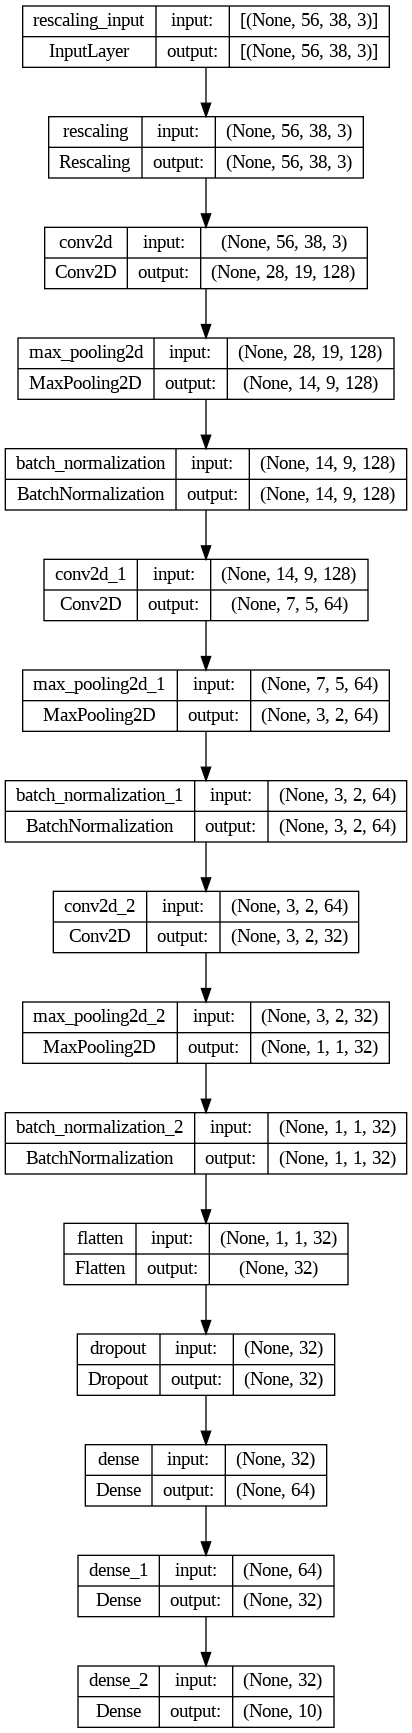

In [10]:
model.summary()
keras.utils.plot_model(model, to_file='my_CNN_for_posters/my_first_model.png', show_shapes=True)

# Создание обратных вызовов(callbacks)

Callback, сохраняющий веса модели в отдельный файл, за счет чего можно продолжать обучение

In [11]:
checkpoint_path = "./my_CNN_for_posters/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

Callback с помощью которого можно менять скорость обучения модели самостоятельно

In [12]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Обучение модели

Возвращает последние веса из файла .ckpt
>запускать только если есть такой файл(уже было обучение модели)

In [13]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)

AttributeError: ignored

Прогоняет их по модели и выводит результат обучаемости

In [14]:
loss, acc = model.evaluate(val_ds, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

325/325 - 13s - loss: 2.3038 - accuracy: 0.0958 - 13s/epoch - 41ms/step
Untrained model, accuracy:  9.58%


Обучение модели

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  shuffle=True,
  callbacks=[callback, cp_callback]
)

loss, acc = model.evaluate(val_ds, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

Epoch 1/15000
 711/1298 [===============>..............] - ETA: 1:40 - loss: 2.2554 - accuracy: 0.1551

Вывод графиков функций точности и потерь на протяжении всего обучения модели

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на обучающих данных')
plt.plot(epochs_range, val_acc, label='Точность на валидационных данных')
plt.legend(loc='lower right')
plt.title('Точность')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на обучении')
plt.plot(epochs_range, val_loss, label='Потери на валидации')
plt.legend(loc='upper right')
plt.title('Потери')
plt.savefig('my_CNN_for_posters/my_network.png')
plt.show()

# Предсказания модели
выполняются по данным из папки test

In [ ]:
for image, lab in val_ds.take(1):
      pred = model.predict(image)
#      print(pred)

for item_path in os.listdir(str(test_dir)):
    item_path = os.path.join(str(test_dir / item_path))
    img = tf.io.read_file(item_path)
    img = tf.image.decode_jpeg(img)
    reshaped_img = tf.image.resize(img, (img_height, img_width))
    reshaped_img = tf.reshape(reshaped_img, (img_height, img_width, 3))
    img_arr = keras.utils.img_to_array(reshaped_img)
    img_arr = tf.expand_dims(img_arr, 0)

    predictions = model.predict(img_arr)
    score = tf.nn.softmax(predictions[0])
    item_name = item_path.split(os.path.sep)[-1]
    print("Score for {}: {}, {}%".format(
        item_name,
        genres_set[np.argmax(score)],
        np.max(score) * 100)
    )